# Delhi Metro Data Analysis
This notebook analyzes and visualizes data from the Delhi Metro dataset using various interactive plots.

Importing Required Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import MarkerCluster, AntPath
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from IPython.display import display

Load the Files

In [15]:
stops = pd.read_csv('stops.txt')
calendar = pd.read_csv('calendar.txt')
routes = pd.read_csv('routes.txt')
trips = pd.read_csv('trips.txt')
stop_times = pd.read_csv('stop_times.txt')
shapes = pd.read_csv('shapes.txt')

Number of Stops per Metro Route

In [16]:

merged = pd.merge(trips, stop_times, on='trip_id')
merged = pd.merge(merged, routes, on='route_id')
stops_per_route = merged.groupby('route_short_name')['stop_id'].nunique().sort_values(ascending=False)
fig = px.bar(x=stops_per_route.index, y=stops_per_route.values,
             labels={'x': 'Route', 'y': 'Number of Stops'}, title='Number of Stops per Metro Route')
fig.show()


Metro Arrival Times by Hour

In [17]:

stop_times['arrival_time'] = pd.to_timedelta(stop_times['arrival_time'], errors='coerce')
stop_times['hour'] = stop_times['arrival_time'].dt.components.hours
fig = px.histogram(stop_times.dropna(subset=['hour']), x='hour', nbins=24,
                   title='Trip Arrival Times Distribution (Hour of Day)', labels={'hour': 'Hour'})
fig.show()


Top 10 Busiest Stations

In [18]:

top_stations = stop_times['stop_id'].value_counts().head(10).reset_index()
top_stations.columns = ['stop_id', 'count']
top_stations = top_stations.merge(stops, on='stop_id')
fig = px.bar(top_stations, y='stop_name', x='count', orientation='h',
             title='Top 10 Busiest Metro Stations', labels={'count': 'Number of Times Appeared'})
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()


## 📅 Analyze Weekly Service Patterns using `calendar.txt`

In [19]:

calendar = pd.read_csv('calendar.txt')
calendar['total_days'] = calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum(axis=1)
fig = px.histogram(calendar, x='total_days', nbins=8, title='Service Coverage (Days per Week)')
fig.update_layout(xaxis_title='Days of Operation per Week', yaxis_title='Number of Services')
fig.show()


Plot Metro Route Paths

In [20]:

shapes = pd.read_csv('shapes.txt')
route_map = folium.Map(location=[28.6139, 77.2090], zoom_start=11)

for shape_id in shapes['shape_id'].unique():
    route = shapes[shapes['shape_id'] == shape_id].sort_values(by='shape_pt_sequence')
    points = list(zip(route['shape_pt_lat'], route['shape_pt_lon']))
    folium.PolyLine(points, weight=3, color='blue', opacity=0.5).add_to(route_map)

route_map


Frequency Heatmap of Station Use

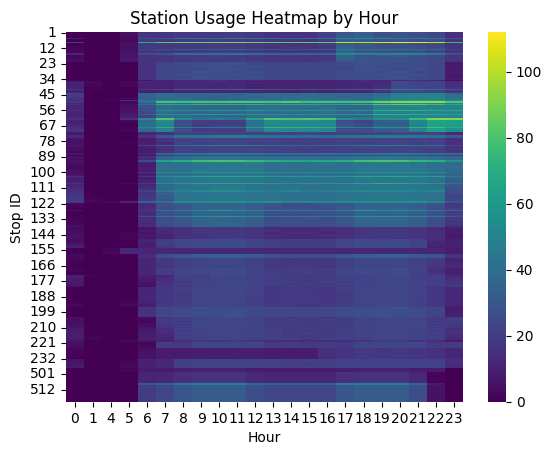

In [21]:
stop_times['arrival_time'] = pd.to_timedelta(stop_times['arrival_time'], errors='coerce')
stop_times['hour'] = stop_times['arrival_time'].dt.components.hours
station_hour = stop_times.groupby(['stop_id', 'hour']).size().unstack(fill_value=0)
sns.heatmap(station_hour, cmap='viridis')
plt.title('Station Usage Heatmap by Hour')
plt.xlabel('Hour')
plt.ylabel('Stop ID')
plt.show()

Trip Duration Estimation

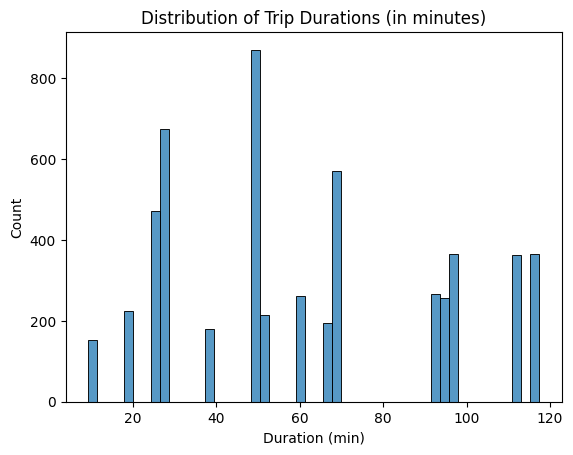

In [22]:
trip_durations = stop_times.groupby('trip_id')['arrival_time'].agg(['min', 'max'])
trip_durations['duration_min'] = (trip_durations['max'] - trip_durations['min']).dt.total_seconds() / 60
sns.histplot(trip_durations['duration_min'].dropna(), bins=50)
plt.title('Distribution of Trip Durations (in minutes)')
plt.xlabel('Duration (min)')
plt.show()

Nearest Stations to a Given Location

In [23]:
coords = stops[['stop_lat', 'stop_lon']].values
tree = KDTree(coords)
your_location = [28.6139, 77.2090]  # Connaught Place
dist, ind = tree.query([your_location], k=5)
nearest = stops.iloc[ind[0]]
display(nearest)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon
52,53,NaN,Udyog Bhawan,NaN,28.611525,77.210052
51,52,NaN,Central Secretariat,NaN,28.614973,77.212029
50,51,NaN,Patel Chowk,NaN,28.622967,77.212288
156,157,NaN,Shivaji Stadium,NaN,28.629007,77.209213
53,54,NaN,Lok Kalyan Marg,NaN,28.597519,77.209122


Clustering of Stations (K-Means)

In [24]:
coords = stops[['stop_lat', 'stop_lon']]
kmeans = KMeans(n_clusters=6, random_state=0).fit(coords)
stops['cluster'] = kmeans.labels_
px.scatter_mapbox(stops, lat='stop_lat', lon='stop_lon', color='cluster',
                  mapbox_style='open-street-map', title='Station Clustering (KMeans)').show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17808\3436746483.py:4: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Predict Busiest Time Window

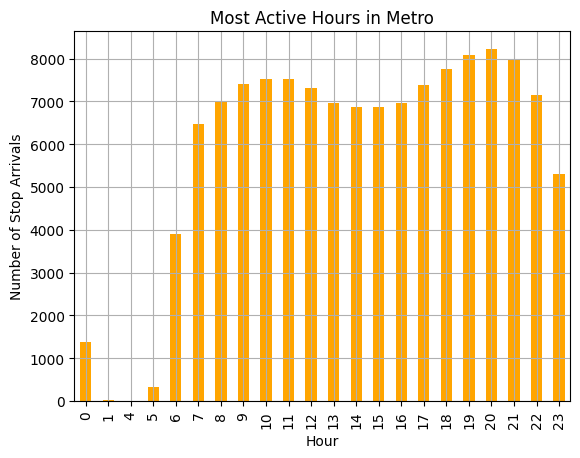

In [25]:
hourly = stop_times.groupby('hour').size()
hourly.plot(kind='bar', color='orange')
plt.title('Most Active Hours in Metro')
plt.xlabel('Hour')
plt.ylabel('Number of Stop Arrivals')
plt.grid(True)
plt.show()

Station Finder(Nearest Station)

In [26]:
user_latlon = (28.6415, 77.2196)
stops['dist'] = np.sqrt((stops['stop_lat'] - user_latlon[0])**2 + (stops['stop_lon'] - user_latlon[1])**2)
closest = stops.sort_values(by='dist').head(1)
display(closest[['stop_name', 'stop_lat', 'stop_lon']])

,stop_name,stop_lat,stop_lon
48,New Delhi,28.642944,77.222351


Animated Route Tracing

In [27]:
m = folium.Map(location=[28.61, 77.23], zoom_start=11)
for shape_id in shapes['shape_id'].unique()[:1]:
    route = shapes[shapes['shape_id'] == shape_id].sort_values(by='shape_pt_sequence')
    points = list(zip(route['shape_pt_lat'], route['shape_pt_lon']))
    AntPath(points, color='blue').add_to(m)
m

Underserved Area Detection

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17808\2353419505.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



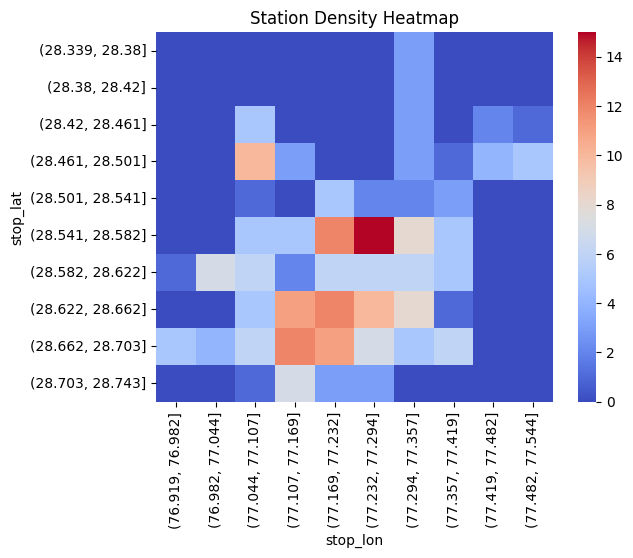

In [28]:
lat_bins = pd.cut(stops['stop_lat'], bins=10)
lon_bins = pd.cut(stops['stop_lon'], bins=10)
heat = stops.groupby([lat_bins, lon_bins]).size().unstack().fillna(0)
sns.heatmap(heat, cmap='coolwarm')
plt.title('Station Density Heatmap')
plt.show()

 Weekday vs Weekend Service Comparison

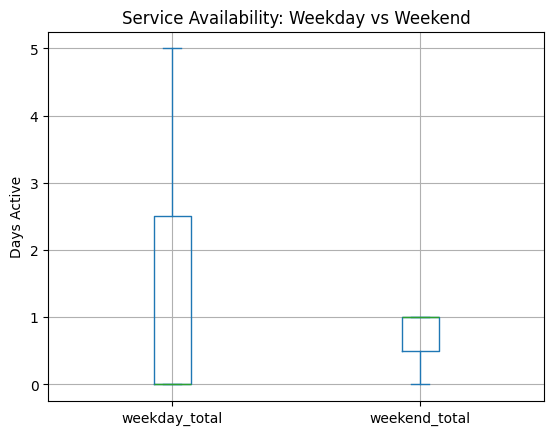

In [29]:
calendar['weekday_total'] = calendar[['monday','tuesday','wednesday','thursday','friday']].sum(axis=1)
calendar['weekend_total'] = calendar[['saturday','sunday']].sum(axis=1)
calendar[['weekday_total', 'weekend_total']].plot(kind='box')
plt.title('Service Availability: Weekday vs Weekend')
plt.ylabel('Days Active')
plt.grid(True)
plt.show()